This notebook evaluates detectron2 results using MAE (Mean Absolute Error), RMSE (Root Mean Square Error), R2 (R-squared).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# Load the CSV files
# Replace 'model_predictions.csv' and 'true_values.csv' with your actual file names
mask_rcnn_predictions_df = pd.read_csv('detectron2-mask_rcnn_R_50_FPN_3x/detectron2_output.csv').fillna(0)
faster_rcnn_predictions_df = pd.read_csv('detectron2-faster_rcnn_R_50_FPN_3x/detectron2_output.csv').fillna(0)
cascade_rcnn_predictions_df = pd.read_csv('detectron2-cascade_rcnn_R_50_FPN_3x/detectron2_output.csv').fillna(0)

mask_rcnn_predictions_df.rename(columns={'people_count': 'mask_rcnn'}, inplace=True)
faster_rcnn_predictions_df.rename(columns={'people_count': 'faster_rcnn'}, inplace=True)
cascade_rcnn_predictions_df.rename(columns={'people_count': 'cascade_rcnn'}, inplace=True)

df = pd.read_csv('people_counts.csv', sep=';')
df = pd.merge(df, mask_rcnn_predictions_df, on='id', how='left')
df = pd.merge(df, faster_rcnn_predictions_df, on='id', how='left')
df = pd.merge(df, cascade_rcnn_predictions_df, on='id', how='left')


In [2]:
def calculate_metrics(predictions, true_values):
    mae = mean_absolute_error(true_values, predictions)
    rmse = root_mean_squared_error(true_values, predictions)
    r2 = r2_score(true_values, predictions)

    return mae, rmse, r2

In [3]:
metric_scores = []
for i in range(1, 101):
    mask = df['people_count'] <= i
    temp_df = df[mask]

    data = []
    data.append(calculate_metrics(temp_df['mask_rcnn'], temp_df['people_count']))
    data.append(calculate_metrics(temp_df['faster_rcnn'], temp_df['people_count']))
    data.append(calculate_metrics(temp_df['cascade_rcnn'], temp_df['people_count']))

    metric_scores.append(pd.DataFrame(data, columns=['mae', 'rmse', 'r2'], index=['mask_rcnn', 'faster_rcnn', 'cascade_rcnn']))


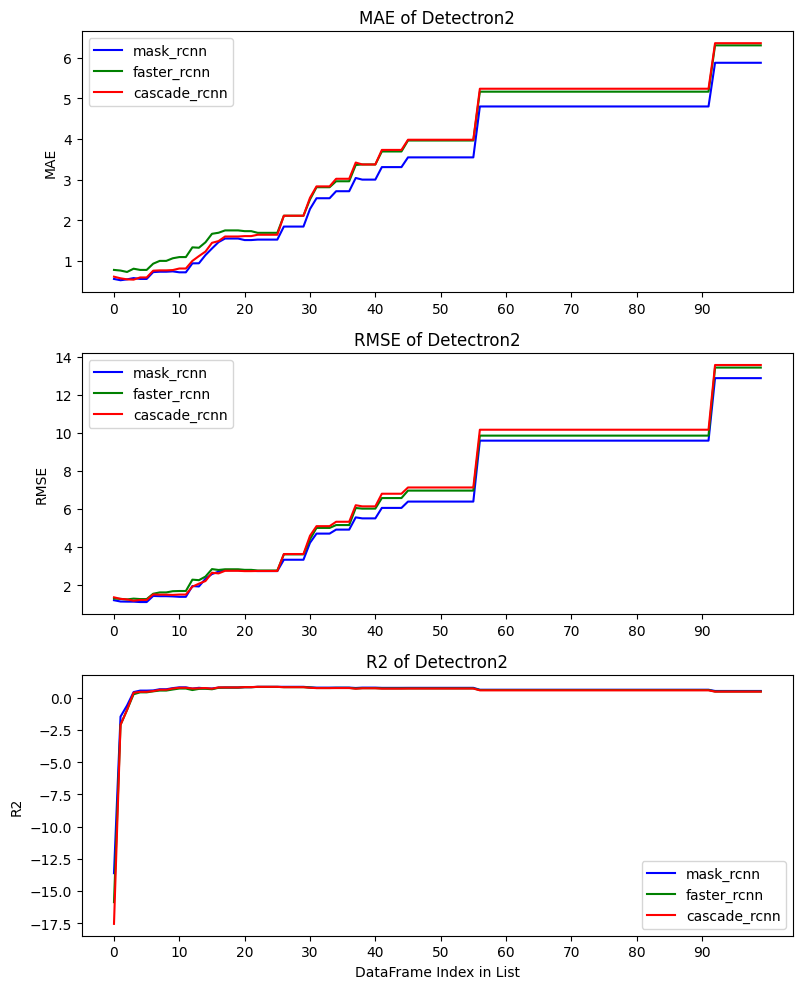

In [4]:
metrics = ['mae', 'rmse', 'r2']
model_labels = ['mask_rcnn', 'faster_rcnn', 'cascade_rcnn']
colors = ['blue', 'green', 'red']

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 10), sharex=False)

for i, metric in enumerate(metrics):
    for model_idx in range(3):  # 3 rows per DataFrame = 3 models
        x_vals = []
        y_vals = []
        
        for df_idx, metric_score in enumerate(metric_scores):
            x_vals.append(df_idx)
            y_vals.append(metric_score.iloc[model_idx][metric])
        
        axes[i].plot(x_vals, y_vals, label=model_labels[model_idx], color=colors[model_idx])
    
    axes[i].set_ylabel(metric.upper())
    axes[i].set_title(f'{metric.upper()} of Detectron2')
    axes[i].legend()

xtick_positions = range(0, len(metric_scores), 10)

for ax in axes:
    ax.set_xticks(xtick_positions)


axes[-1].set_xlabel('DataFrame Index in List')
plt.tight_layout()
plt.show()